In [1]:
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], "src"))

## Prepare single robot scene

In [2]:
from pkg.utils.test_scripts import *
from pkg.controller.robot_config import *

ROBOT_TYPE = RobotType.panda
ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, HOME_POSE, GRIP_DEPTH = get_single_robot_params(ROBOT_TYPE)
s_buillder, pscene = prepare_single_robot_scene(
    ROBOT_TYPE=ROBOT_TYPE, ROBOT_NAME=ROBOT_NAME, TOOL_LINK=TOOL_LINK, TOOL_XYZ=TOOL_XYZ, TOOL_RPY=TOOL_RPY)
gscene = pscene.gscene

connection command:
panda0: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## Prepare dummy object

In [3]:
gscene.create_safe(gtype=GEOTYPE.BOX, name="obj", link_name="base_link", 
                   dims=(0.05,0.05,0.05), center=(0,0,0.025), rpy=(0,0,0), fixed=False)

from pkg.planning.constraint.constraint_subject import BoxObject
obj = pscene.create_subject(oname="obj", gname="obj", _type=BoxObject)
from pkg.planning.constraint.constraint_actor import Gripper2Tool
grip = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool, point=(0,0,0))

## Prepare planner

In [4]:
from pkg.planning.constraint.constraint_common import BindingTransform
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene=pscene)

In [5]:
from pkg.planning.filtering.reach_filter import ReachChecker
rcheck = ReachChecker(pscene)

sheight = rcheck.shoulder_height_dict[ROBOT_NAME]
sreach = rcheck.shoulder_reach_dict[ROBOT_NAME]

## check with ReachTrainer and test dataset

In [6]:
from pkg.planning.filtering.reach_filter import ReachTrainer, features2T, xyzquat2features, T2features, to_featurevec
rtrain = ReachTrainer(scene_builder=s_buillder)

In [7]:
goalpose_list, success_list = rtrain.load_data(ROBOT_TYPE, "test")
goalpose_list = np.array(goalpose_list)

In [8]:
gtimer = GlobalTimer.instance()
gtimer.reset()
T_list = []
result_list = []
for goalpose in goalpose_list:
    features = xyzquat2features(goalpose, rcheck.shoulder_height_dict[ROBOT_NAME])
    T = features2T(*features)
    xyz = T[:3,3]
    orientation_mat = T[:3,:3]
    Tloal = SE3(orientation_mat, xyz)
    btf = BindingTransform(obj, None, grip, T_loal=Tloal)
    with gtimer.block("ReachChecker"):
        rfeas = rcheck.check(btf, pscene.combined_robot.home_dict)
    xyz, quat = T2xyzquat(Tloal)
    for _ in range(30):
        ikres = mplan.planner.solve_ik_py(ROBOT_NAME, xyz + quat, self_collision=True) is not None
        if ikres:
            break
    T_list.append(Tloal)
    result_list.append((rfeas, ikres))
result_list = np.array(result_list)
print("ik sanity: {:.04}".format(np.mean(result_list[:,1]==success_list)*100))
print("accuracy : {:.04}".format(np.mean(result_list[:,1]==result_list[:,0])*100))
print(gtimer)

KeyboardInterrupt: 

```
ik sanity: 99.36
accuracy : 94.52
ReachChecker: 	1494.0 ms/5000 = 0.3 ms (0.209/1.031)

```

## Test new data

In [20]:
gtimer = GlobalTimer.instance()
gtimer.reset()
T_list = []
result_list_new = []
featurevec_list_new = []
for i in range(1000):
    while True:
        xyz_shoulder = np.random.uniform(-0.85, 0.85, size=3)
        sradii = np.linalg.norm(xyz_shoulder)
        xyz = xyz_shoulder + [0,0,sheight]
        if np.linalg.norm(xyz[:2])>0.2 and sradii<sreach:
            break
    rpy = np.random.uniform(0, np.pi*2, size=3)
    R = Rot_rpy(rpy)
#     radius, theta, height = cart2cyl(*xyz)
#     azimuth_loc = np.random.uniform(-np.pi, np.pi)
#     zenith = np.arccos(np.random.uniform(-np.cos(0), -np.cos(np.pi)))
#     hori_bak = (azimuth_loc, zenith)
#     R = hori2mat(azimuth_loc=azimuth_loc, zenith=zenith, theta=theta)
# #     gscene.add_highlight_axis(hl_key="rc", name="a%03d"%i, link_name="base_link", center=xyz, orientation_mat=R,
# #                              dims=(0.2,0.005,0.005))
#     R = np.matmul(R, Rot_axis(3, np.random.uniform(-np.pi, np.pi)))
# #     gscene.add_highlight_axis(hl_key="rc", name="b%03d"%i, link_name="base_link", center=xyz, orientation_mat=R,
# #                              dims=(0.1,0.02,0.02))
#     hori_rgn = mat2hori(R, theta=theta)
#     assert np.linalg.norm(np.subtract(hori_bak, hori_rgn)) < 1e-6, "z rotation makes unexpected change in horizonotal coordinates"
    Tloal = SE3(R, xyz)
    
    features = T2features(Tloal, sheight)
    featurevec = to_featurevec(*features)
    featurevec_list_new.append(featurevec)
    btf = BindingTransform(obj, None, grip, T_loal=Tloal)
    with gtimer.block("ReachChecker"):
        rfeas = rcheck.check(btf, pscene.combined_robot.home_dict)
    xyz, quat = T2xyzquat(Tloal)
    for _ in range(30):
        ikQ = mplan.planner.solve_ik_py(ROBOT_NAME, xyz + quat, self_collision=True)
        ikres = ikQ is not None
        if ikres:
            break
#     gscene.add_highlight_axis(hl_key="rc", name="%03d"%i, link_name="base_link", center=xyz, orientation_mat=R, axis="y",
#                              color=np.add((1,0,0,1) if rfeas else (0,0,0,1), (0,0,1,0) if ikres else (0,0,0,0)),
#                              dims=(0.05,0.005,0.005) if rfeas==ikres else (0.1,0.01,0.01))
    T_list.append(Tloal)
    result_list_new.append((rfeas, ikres))
#     if ikres:
#         gscene.show_pose(ikQ)
#         break
result_list_new = np.array(result_list_new)
featurevec_list_new = np.array(featurevec_list_new)
print("accuracy : {:.04}".format(np.mean(result_list_new[:,1]==result_list_new[:,0])*100))
print(gtimer)

accuracy : 94.4
ReachChecker: 	255.7 ms/1000 = 0.3 ms (0.21/0.914)



#### uniform rpy sampling
```
accuracy : 94.4
ReachChecker: 	255.7 ms/1000 = 0.3 ms (0.21/0.914)
```
#### horizontal + rpt_z sampling
```
accuracy : 94.3
ReachChecker: 	291.1 ms/1000 = 0.3 ms (0.21/1.167)
```

## plot feature vector depending on TP/FP/FN/TN

In [52]:
print("========== Saved Results ==========")
print_confusion_mat(result_list[:,1], result_list[:,0])
print("===================================")

print("=========== New Results ===========")
print_confusion_mat(result_list_new[:,1], result_list_new[:,0])
print("===================================")

========== Saved Results ==========
           PP         PN       5000
GP       2961         91     97.02%
GN        183       1765     90.61%
AL     94.18%     95.10%     94.52%
=========== New Results ===========
           PP         PN       1000
GP        600         17     97.24%
GN         39        344     89.82%
AL     93.90%     95.29%     94.40%


## show distribution

In [26]:
from pkg.utils.plot_utils import scatter_3d

Text(0.5,0,'y')

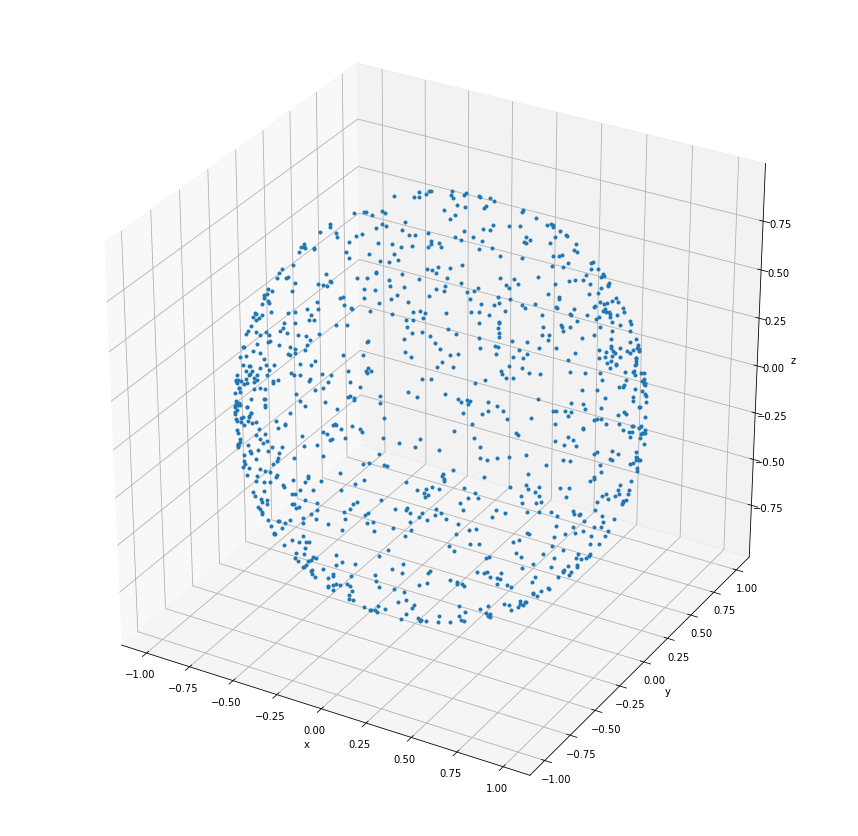

In [27]:
vec_list = []
for fvec in featurevec_list_new:
    mat = hori2mat(azimuth_loc=fvec[3], zenith=fvec[4], theta=0)
    vec_list.append(mat[:,2])
scatter_3d(vec_list)
plt.xlabel("x")
plt.ylabel("y")